In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imgaug import augmenters as iaa

import cv2
import os
from sklearn.model_selection import train_test_split
import random
import glob
import pandas as pd
import sys
from time import time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,Dense,Dropout,MaxPool2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

## Load Data
We will now get the filepaths of our images and append them to a 1D array. We will also get the steering data from the filename and append that to our labels array.

In [2]:
dataset = 'SNES_410x200'
images=[]
steering=[]

for folder in os.listdir(dataset):
    for img in os.listdir(os.path.join(dataset,folder)):
        images.append(os.path.join(dataset,folder,img))
        
        x_coord=float((int(img.split('_')[2]) - 960 ) / 960) # Normalize data, as screen width = 1920 remove 1 because zero indexed
        steering.append(x_coord)

## Visualise data
View our labels with matplotlib to check that they are balanced and that everything is working so far.

<BarContainer object of 35 artists>

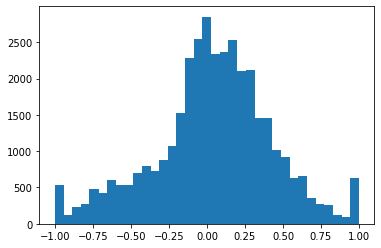

In [3]:
nBins=35
samplesPerBin=1000

hist,bins = np.histogram(steering,nBins)
center=(bins[:-1]+bins[1:])*0.5

plt.bar(center,hist,width=0.06)

## Split Data
We will split our data for training and testing

In [4]:
X_train,X_test,y_train,y_test=train_test_split(images,steering,test_size=0.05)
print(len(X_train),len(X_test))

34610 1822


## Define Preprocessing Function

In [5]:
def preProcessing(img):
    img=cv2.cvtColor(img,cv2.COLOR_RGB2YUV)#[30:60,70:130] # img[40:200,200:700]
    img=img/255
    return img

## Setup Image Augmentation

In [21]:
def augmentImage(img,steering):
    img=mpimg.imread(img) # 820x400

    random_float1 = random.randrange(5,10)*0.1
    random_float2 = random.randrange(5,10)*0.1
    random_float3 = random.randrange(5,10)*0.1
    
    x = 140
    y = 90
    cv2.rectangle(img, (x, y), (250, 190), (90,86,74), -1)

    # if random.randint(0,1):
    #     img = cv2.bitwise_not(img)
        
    if random.randint(0,1):
        img[:, :, 0] = img[:,:,0]*random_float1 # we can't multipy by random.randrange directly because
                                                # a new random number is generated evertime we multiply
    if random.randint(0,1):
        img[:, :, 1] = img[:,:,1]*random_float2
        
    if random.randint(0,1):
        img[:, :, 2] = img[:,:,2]*random_float3
        
    # if random.randint(0,1):
    #     img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if random.randint(0,1):
        img = iaa.Affine(translate_percent={'x':(-0.1,0.1),'y':(-0.1,0.1)}).augment_image(img)
        
    if random.randint(0,1): 
        img = iaa.Affine(scale=(1,1.1)).augment_image(img)
    
    #if random.randint(0,1):
    img = iaa.Multiply((1,2)).augment_image(img)
    
    if random.randint(0,1):
        img = cv2.flip(img,1)
        steering =- steering
    return img,steering

## Create Batches

Shape = (200, 410, 3)


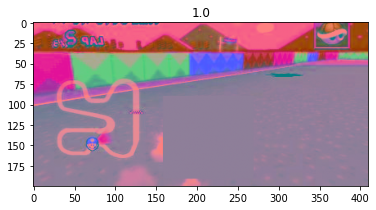

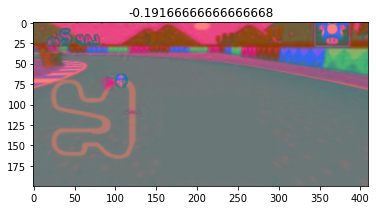

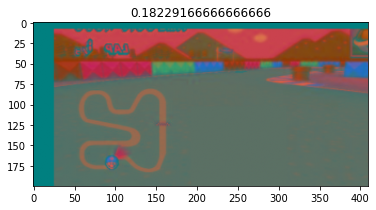

In [22]:
def create_batch(imagePath,steeringList,batch_size=32,augment=True):
  
    while True: # every time the generator object is called we repeat this
        imgBatch = []
        steeringBatch = []

        for i in range(batch_size):
            index=random.randint(0,len(steeringList)-1)
            img=imagePath[index]
            steering=steeringList[index]
            
            if augment:
                img, steering = augmentImage(img,steering)    
            else:
                img = mpimg.imread(img)
            
            img = preProcessing(img)
            imgBatch.append(img)
            steeringBatch.append(steering)
            
        yield (np.asarray(imgBatch),np.asarray(steeringBatch))


        
test=create_batch(X_test,y_test,3,augment=True)

test=next(test)
plt.figure(1)
plt.title(test[1][0])
plt.imshow(test[0][0])

# Compute image shape for model
img_shape = test[0][0].shape
print(f'Shape = {img_shape}')

plt.figure(2)
plt.title(test[1][1])
plt.imshow(test[0][1])

plt.figure(3)
plt.title(test[1][2])
plt.imshow(test[0][2])

## Build Model


In [28]:
model_name = f'v5.7_rgb_color_augmentation_YUV_no_invert_or_bgr'
def createModel():
    model=Sequential(name=model_name)
    
    model.add(Conv2D(24,(3,3),(2,2),input_shape=img_shape,activation='elu'))
    #model.add(Convolution2D(36,(5,5),(2,2),activation='elu'))
    model.add(Conv2D(48,(3,3),(2,2),activation='elu'))
    model.add(MaxPool2D((4,4),strides=(4,4)))
    model.add(Dropout(0.2))
    # model.add(Convolution2D(64,(3,3),activation='elu'))
    model.add(Conv2D(64,(3,3),activation='elu'))

    model.add(Flatten())
    
    model.add(Dense(100,activation='elu'))
    model.add(Dense(50,activation='elu'))
    model.add(Dense(10,activation='elu'))
    model.add(Dense(1))

    model.compile(Adam(learning_rate=0.0001),loss='mse')

    return model


checkpoint = ModelCheckpoint(os.path.join('models',model_name,f'{model_name[:4]}'+'_epoch={epoch}.h5'),save_freq='epoch') # can't use f strings on second part

model=createModel()

history=model.fit(create_batch(X_train,y_train,batch_size=32),steps_per_epoch=300,epochs=20,validation_data=create_batch(X_test,y_test,32,augment=False),validation_steps=40,callbacks=[checkpoint])

## Evaluate model and testing

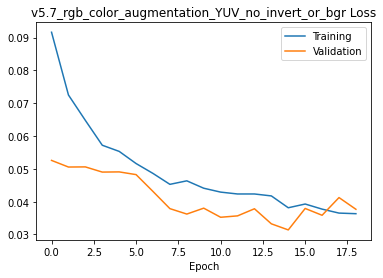

In [24]:
def eval_model(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.legend(['Training','Validation'])
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.savefig(f'{model_name}.png')
  
eval_model(history)

## Testing the model

In [25]:
eval_imgs, y_true = next(create_batch(X_test,y_test,512,augment=False))

model_name = []
model_mse = []
model_r_score = []

old_time = time()

for version_dir in os.listdir('models'):
    for model_path in glob.glob(os.path.join('models',version_dir,'*h5')):
        model = load_model(model_path)
        #model = load_model(os.path.join('models','models_v5.3','model00000010.h5'))
        
        try:
            y_pred = model.predict(eval_imgs)
            
            mse = mean_squared_error(y_true,y_pred)
            r_squared = r2_score(y_true,y_pred)

            model_name.append(os.path.split(model_path)[-1])
            model_mse.append(mse)
            model_r_score.append(r_squared)
            
            
            sys.stdout.write(f'\rEvaluating: {os.path.split(model_path)[-1]}, time = {round(time()-old_time,2)}s')
            sys.stdout.flush()
            old_time = time()
            

        except:
            print(os.path.split(model_path)[-1], 'incompatiable with dataset')

data = {'Model':model_name,
        'MSE':model_mse,
        'R Squared':model_r_score}

df = pd.DataFrame(data)
df = df.sort_values(by=['R Squared'],ascending=False)

print(f'\n\n{df.head(100)}')
df.to_csv('model_scores.csv',index=False)

Evaluating: v5.7_epoch=9.h5, time = 1.3s

               Model       MSE  R Squared
76  v5.7_epoch=16.h5  0.030288   0.773988
74  v5.7_epoch=14.h5  0.032726   0.755799
75  v5.7_epoch=15.h5  0.033080   0.753155
81  v5.7_epoch=20.h5  0.034799   0.740331
73  v5.7_epoch=13.h5  0.034917   0.739450
..               ...       ...        ...
20   v5.4_epoch=1.h5  0.108483   0.190498
47   v5.5_epoch=2.h5  0.110096   0.178465
40   v5.5_epoch=1.h5  0.123743   0.076627
10  model00000001.h5  0.128741   0.039331
55   v5.6_epoch=1.h5  0.130561   0.025748

[89 rows x 3 columns]


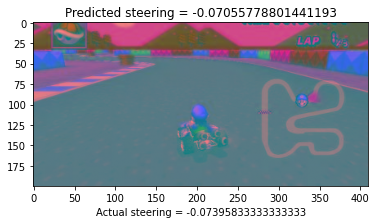

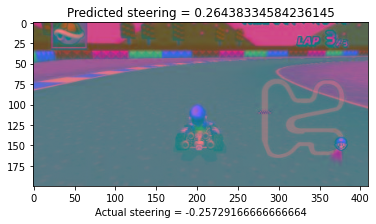

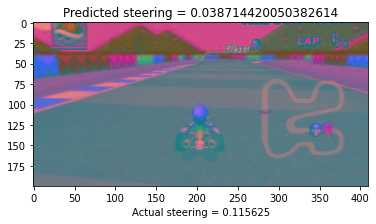

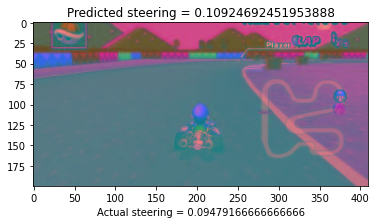

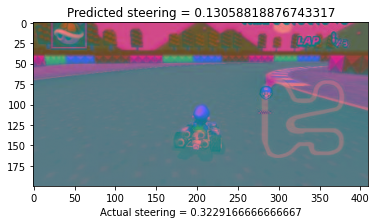

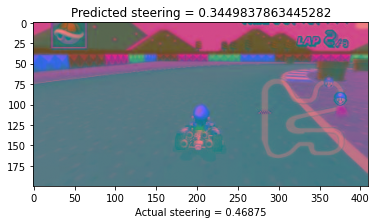

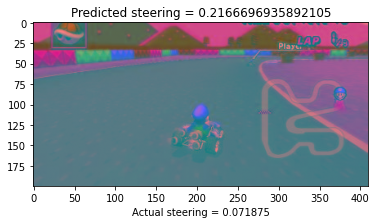

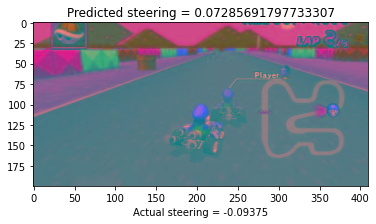

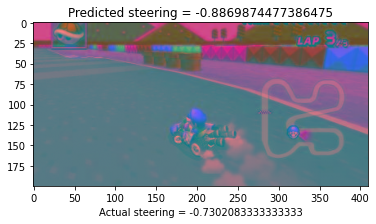

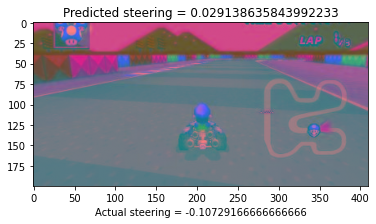

In [30]:
model_name = f'v5.7_rgb_color_augmentation_YUV_no_invert_or_bgr'
model = load_model(os.path.join('models',model_name,f'{model_name[:4]}'+'_epoch=16.h5'))

seed = random.randint(0,len(X_test)-16)
for i,img in enumerate(X_test[seed:seed+10]):
    test_img = preProcessing(mpimg.imread(img))    
    steering = model.predict(np.asarray([test_img]))[0][0]
    plt.title(f'Predicted steering = {steering}')
    plt.xlabel(f'Actual steering = {y_test[seed+i]}')
    plt.imshow(test_img)
    plt.show()

